# Past cropping outcomes

Code to make final figure for manuscript.

Last updated: 19 October 2020

### Goal: Extract alphas, lambdas from 1930s and 2010s climatology

Followed Kelly's steps on Slack:

<img src="methods_sketch.png" style="width: 600px">

1. The blue lines in each plot represent the average annual change in either parameter over the period of observation.
2. We can use the entire record to get an estimate of the alpha and lambda for each decad (let’s call this the “seasonally-varying” component of climate, which is determined by the ITCZ, etc…)
3. Those average decad values would correspond to the typical climate in the middle of the record.
4. To get at the recent (or past) values, we just apply the trend line to each of the individual average decads to see what the “2020” or “1940" values would be.

For example:
alpha_decad_1(1940) = average_alpha_decad_1  d_seasonal_alpha/dt * 30 years
(assuming the middle of the observation period is 1970)
d_seasonal_alpha/dt  is the slope of the blue line for seasonal alpha. 

We use the long-term seasonal trends for each parameter to adjust the long-term average values for each decad in order to obtain historical (or future) values of the parameters in each decad.


In [1]:
## We need to add the module path to our system path so 
## so that our notebook can find our local objects and code:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
     
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from math import exp
import seaborn as sns
import sys
import glob
from dateutil.relativedelta import *
from numpy.random import exponential, uniform
import scipy.stats as st
from statistics import mean 

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *
from farm.climate import make_climate_parameters, check_exponential, Climate

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

## Steps:

#### 1. The blue lines in each plot represent the average annual change in either parameter over the period of observation.

These values are from the trend graphs in `1-rainfall-variability-stats`.

In [2]:
# Make a plot of the slopes for Jacobson Farm for alpha and lambda
t = pd.Series(np.arange(1934, 2015, 1))

# Easier to manually import the values for slope and intercept
# These came from the regression line of seasonal trends for Jacobson Farm

m_al = 0.06616878857577158 # Slope, alpha
m_ll = -0.002652831781941007 # Slope, lambda

c_al = -121.90153294377794 # Intercept, alpha
c_ll = 5.578343185001898 # Intercept, lambda

#### 2. We can use the entire record to get an estimate of the alpha and lambda for each decad (let’s call this the “seasonally-varying” component of climate, which is determined by the ITCZ, etc…)

Seasonally varying component = alpha and lambdas as they stand normally in the code.

In [3]:
# This is for Jacobson Farm
station = 'JACOBSON FARM'
interval='dekad'
data_file="../data/CETRAD/CETRAD_rainfall.csv"

a_mid, l_mid, sd = make_climate_parameters(data_file = data_file, station=station, interval=interval) 

# Make a dataframe with these alphas and lambdas
# These will be our alphas and lambdas for the middle of the time series                                                                              ]})
df_mid = pd.DataFrame({'alpha':a_mid, 'lambda':l_mid, 'dekad':np.arange(1,38,1),'doy':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                             '170','180','190','200','210','220',
                                                                             '230','240','250','260','270','280','290',
                                                                              '300','310','320','330','340','350','360','365'
                                                                              ]})

#### 3. Those average decad values would correspond to the typical climate in the middle of the record.

Use those values for alpha, `a_mid`, and lambda, `l_mid`, as the typical climate in the middle of the record. Run the models.

In [4]:
def run(alpha_r=None, lambda_r=None,n_sim = 10000, burn_in = 60,  station = 'OL JOGI FARM', data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv',
    texture = 'clay loam', lgp=180, pd_sim=60, interval='dekad'):
    """ Set up model conditions for model runs. 

    Usage: run(n_sim, burn_in, station, data_file, texture, lgp, pd_sim, interval)
           
    Default values:
        n_sim = 1000 # Number of Simulations to Remove Initial Conditions [integer]
        burn_in = 60 # Number of Days to Run for Initial Conditions Removal [integer]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [days]
        pd_sim 100 # Planting Date for Simulation [day of year]
        data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv' # Location of Rainfall Data [csv file]
        interval = 'dekad' # Time interval to calculate alpha and lambda parameters [string]

    """
    ## Step 1: Run model
    # Part 1. Set conditions for IC runs
    doy = pd_sim - burn_in
    while doy < 1:
        doy = 365 + doy
    
    print("Step 1: \n\t...Conducting burn in starting at doy {doy}, which is {burn_in} days before the simulated planting date of {pd_sim}.".format(
        doy=doy,
        burn_in=burn_in,
        pd_sim=pd_sim)
    )
    
    # Part 2. Initialize model with a climate, soil and crop
    print("Step 2: \n\t...Initializing {interval} lamba and alphas based on {station} using {data_file}.".format(
        interval=interval,
        station=station,
        data_file=data_file)
    )
    
    s0_climate = Climate(
        data_file=data_file,
        station=station,
        interval=interval,
        alpha_r=alpha_r, lambda_r=lambda_r,
        do_std=True)
    
    print("\t...Initializing soil as {texture}".format(texture=texture))
    soil = Soil(texture=texture)
    
    print("\t...Initializing crop with {lgp} days to maturity".format(lgp=lgp))
    crop = Crop(soil=soil, lgp=lgp)
    
    print("\t...Setting nZr parameter to {nZr}".format(nZr=soil.set_nZr(crop)))
    soil.set_nZr(crop)
    
    model = CropModel(crop=crop, climate=s0_climate, soil=soil)
    
    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    n_burn_in_sims = max(10, int(n_sim*.10))
    print("Step 3: \n\t... Setting number of burn in simulations to {n_burn_in_sims}".format(
        n_burn_in_sims=n_burn_in_sims)
    )
    
    print("\t...Computing average soil moisture for doy {doy} using {n_sim} simulations".format(
        doy=doy,
        n_sim=n_burn_in_sims)
    )
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_burn_in_sims, doy=doy)
    print("\t\t[s0_mean]:{s0_mean}\t[s0_std]:{s0_std}".format(
        s0_mean=s0_mean,
        s0_std=s0_std)
    )
    models = [CropModel(
                  crop=crop,
                  climate=Climate(
                      alpha_r=s0_climate.alpha_r,
                      lambda_r=s0_climate.lambda_r,
                      lambda_std=s0_climate.lambda_std,
                      do_std=True), # Added variability to lambda.
                  soil=soil) for i in np.arange(n_sim)
               ]
    
    # Part 4. Run the actual simulations 
    print("Step 4: \n\t... Running {n_sim} simulations.".format(n_sim=n_sim))
    # We imported printProgressBar from functions.py earlier:
    printProgressBar(0, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)
    output = []
    for i, model in enumerate(models):
        output.append(model.run(s0=s0_mean, do_output=True, t_before=burn_in, planting_date=pd_sim))
        printProgressBar(i + 1, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)
    #output = [model.run(s0=s0_mean, do_output=True, t_before=burn_in, planting_date=pd_sim) for model in models]

    print("\t... Done.")

    # Part 5. Subset the growing period and get avg soil moisture
    print("Step 5: \n\t...Subsetting data to growing period.")
 
    start = burn_in 
    end = start + lgp
    avg_s = [df[start:end]['s'].mean() for df in output]
    
    # Part 6. Output the dynamic stress and yield values
    print("Step 6: \n\t...Calculating plant stress.")

    x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress, Y_MAX = evolved_calc_yield(dtm=lgp)) for df in output]
    
    rf = [df[start:end]['R'].sum() for df in output]
    
    return x, rf, int(lgp), avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in

In [5]:
x, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = run(
    alpha_r=a_mid, lambda_r=l_mid, n_sim=10000)

Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on OL JOGI FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
	...Initializing soil as clay loam
	...Initializing crop with 180 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 1000
	...Computing average soil moisture for doy 365 using 1000 simulations
		[s0_mean]:0.5471881464800692	[s0_std]:0.05548317727202794
Step 4: 
	... Running 10000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.


In [6]:
# Define variables
# soil = Soil(texture=texture)
# crop = Crop(soil=soil, lgp=lgp)
# soil.set_nZr(crop)

# Generate end of season yield, total rainfall from output
data = [crop.calc_dstress(s=d.s, stress=d.stress) for d in output] 
RF = [d['R'].sum() for d in output]
result = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
result['RF'] = RF

# Save this time series as the middle time series. Will concatenate them all later

# Cat them all together
result['Era'] = 'mid'
result

,AvgStress,DynamicStress,Yield,RF,Era
0,0.657192,1.000000,0.000000,251.094206,mid
1,0.238228,0.469377,2260.454364,740.261647,mid
2,0.532885,1.000000,0.000000,320.639290,mid
3,0.191844,0.455443,2319.811585,585.062220,mid
4,0.373889,0.639162,1537.170135,528.090471,mid
...,...,...,...,...,...
9995,0.285112,0.600247,1702.946984,619.832810,mid
9996,0.283735,0.546079,1933.705238,551.710750,mid
9997,0.453297,0.695812,1295.842184,457.675187,mid
9998,0.443987,0.742900,1095.244387,394.173957,mid


#### 4. To get at the recent (or past) values, we just apply the trend line to each of the individual average decads to see what the “2020” or “1940" values would be.



In [7]:
# There are 80 years in the record (1934-2014), so we'll add or subtract by 40 years.
# df_mid corresponds to the alpha and lambdas we use for the middle or average values

alphas_2010 = df_mid['alpha']+m_al*40; alphas_2010
alphas_1930 = df_mid['alpha']-m_al*40; alphas_1930

lambdas_2010 = df_mid['lambda']+m_ll*40; lambdas_2010 
lambdas_1930 = df_mid['lambda']-m_ll*40

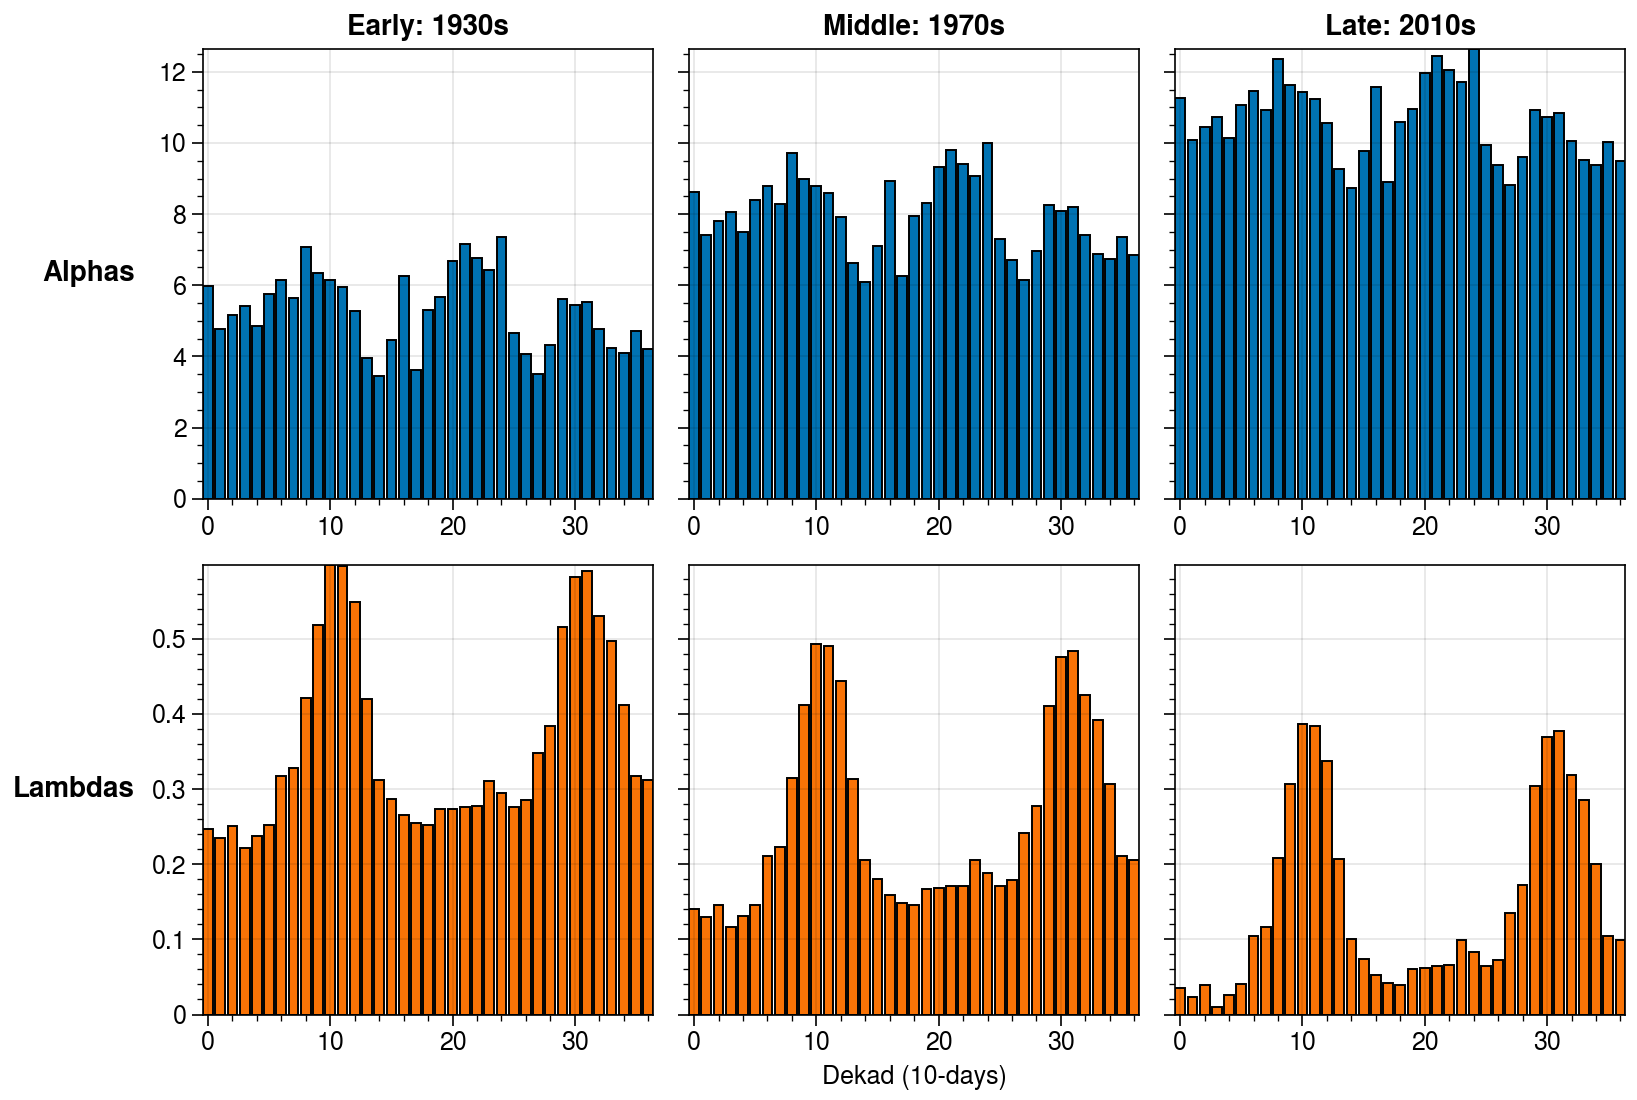

In [8]:
# Make three bar subplots of the deakadal alphas and lambdas
f, ax = plot.subplots(nrows=2, ncols=3, sharex=True) # , sharey=1

ax.format(
    rowlabels=['Alphas', 'Lambdas'],
    collabels=['Early: 1930s', 'Middle: 1970s', 'Late: 2010s']
)

ax[0,0].bar(alphas_1930)
ax[0,1].bar(df_mid.alpha)
ax[0,2].bar(alphas_2010)

ax[1,0].bar(lambdas_1930, color='orange')
ax[1,1].bar(df_mid['lambda'], color='orange')
ax[1,2].bar(lambdas_2010, color='orange')

# Good ol labels
#ax[0:].format(ylabel='Avg. depth per storm (mm)')
#ax[1:].format(ylabel='Inter-storm arrival rate (day^-1)')
ax[:3:2].format(xlabel='Dekad (10-days)')
ax[1:].format(ylabel='')

In [9]:
# Run the sims for 2010
x, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = run(alpha_r=alphas_2010, 
    lambda_r=lambdas_2010, burn_in = 60, texture = 'clay loam', lgp=180, pd_sim=60, interval='dekad',n_sim=10000
       )

# Generate end of season yield, total rainfall from output
data = [crop.calc_dstress(s=d.s, stress=d.stress) for d in output] 
RF = [d['R'].sum() for d in output]

result_2010 = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
result_2010['RF'] = RF
result_2010['Era'] = 'late'


Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on OL JOGI FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
	...Initializing soil as clay loam
	...Initializing crop with 180 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 1000
	...Computing average soil moisture for doy 365 using 1000 simulations
		[s0_mean]:0.5515692651481597	[s0_std]:0.05680149644053529
Step 4: 
	... Running 10000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.


In [10]:
# Run the sims for 1930s
x, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = run(
    alpha_r=alphas_1930, lambda_r=lambdas_1930, burn_in = 60, texture = 'clay loam', lgp=180, 
    pd_sim=60, interval='dekad',n_sim=10000
       )

# Generate end of season yield, total rainfall from output
data = [crop.calc_dstress(s=d.s, stress=d.stress) for d in output] 
RF = [d['R'].sum() for d in output]

result_1930 = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
result_1930['RF'] = RF
result_1930['Era'] = 'early'


Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on OL JOGI FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
	...Initializing soil as clay loam
	...Initializing crop with 180 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 1000
	...Computing average soil moisture for doy 365 using 1000 simulations
		[s0_mean]:0.58564623851649	[s0_std]:0.053809080054290144
Step 4: 
	... Running 10000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.


In [11]:
# Cat the three dataframes together
result_list = [result_1930, result, result_2010]
pd.concat(result_list)

,AvgStress,DynamicStress,Yield,RF,Era
0,0.293990,0.521363,2038.993881,591.729035,early
1,0.218057,0.484606,2195.576857,674.812685,early
2,0.398654,0.659275,1451.489215,570.317742,early
3,0.497949,1.000000,0.000000,384.117241,early
4,0.319236,0.608461,1667.956599,457.273334,early
...,...,...,...,...,...
9995,0.541983,1.000000,0.000000,339.967986,late
9996,0.550290,1.000000,0.000000,299.358182,late
9997,0.604781,1.000000,0.000000,291.462503,late
9998,0.291415,0.531066,1997.657337,512.433879,late


In [16]:
# Do table and plot

table = pd.DataFrame({'Rainfall Climatology':['Early: 1930s','Middle: 1970s (Avg)','Late: 2010s'],
                   # 'Rainfall Climatology':['1935-1940','1972-1977','2010-2015']
            'Maize Variety':[180,180,180],
            'Average Alpha (mm)':[mean(alphas_1930), mean(a_mid), mean(alphas_2010)],
            'Average Lambda (day^-1)':[mean(lambdas_1930), mean(l_mid), mean(lambdas_2010)],
            'Average Rainfall (mm)':[result_1930.RF.mean(), result.RF.mean(), result_2010.RF.mean()],
            'SD Rainfall':[np.std(result_1930.RF),np.std(result.RF),np.std(result_2010.RF)],
            'CV Rainfall':[result_1930.RF.std()/result_1930.RF.mean(), 
                                result.RF.std()/result.RF.mean(),
                                result_2010.RF.std()/result_2010.RF.mean()],
            'Average Yield (t/ha)': [np.nanmean(result_1930.Yield/1000), 
                                     np.nanmean(result.Yield/1000), 
                                     np.nanmean(result_2010.Yield/1000)],
            'Probability of Crop Failure (%)':[len(result_1930.loc[result_1930['Yield'] == 0].count(axis=1))/len(result_1930)*100,
                                               len(result.loc[result['Yield'] == 0].count(axis=1))/len(result)*100,
                                               len(result_2010.loc[result_2010['Yield'] == 0].count(axis=1))/len(result_2010)*100]})
table

,Rainfall Climatology,Maize Variety,Average Alpha (mm),Average Lambda (day^-1),Average Rainfall (mm),SD Rainfall,CV Rainfall,Average Yield (t/ha),Probability of Crop Failure (%)
0,Early: 1930s,180,5.318634,0.360060,580.041303,131.685739,0.227040,1.667889,4.96
1,Middle: 1970s (Avg),180,7.965385,0.253947,427.748470,122.648491,0.286745,0.991484,24.79
2,Late: 2010s,180,10.612137,0.147834,443.983347,121.859721,0.274483,1.067194,21.23


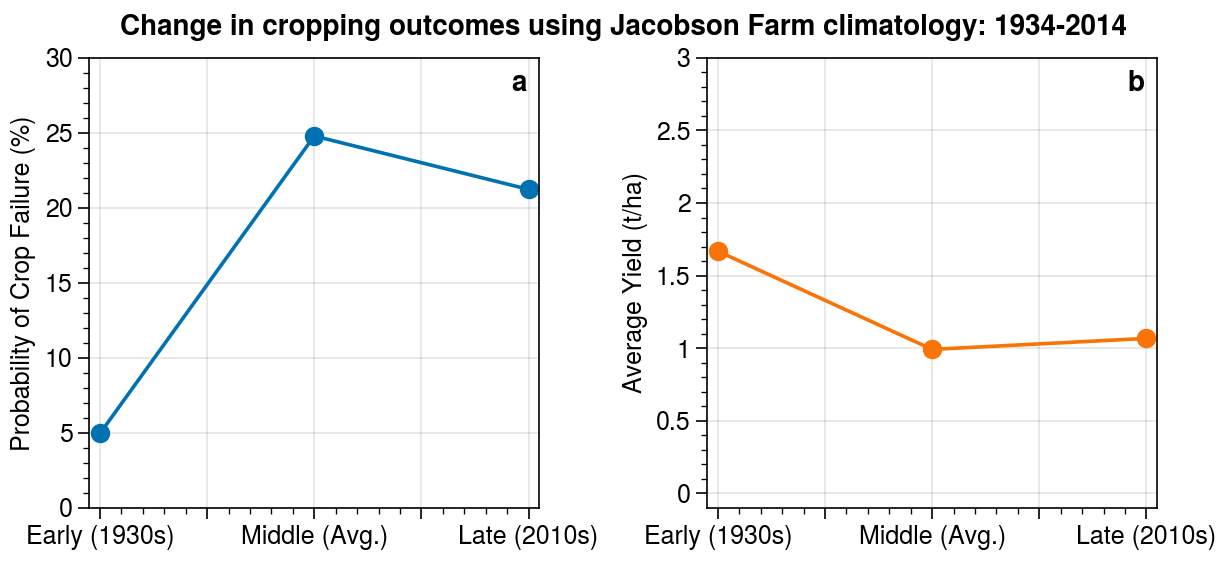

In [17]:
# Make final figure for manuscript

f, ax = plot.subplots(nrows=1, ncols=2, sharex=True, sharey=False)
ax.format(
         suptitle='Change in cropping outcomes using Jacobson Farm climatology: 1934-2014',
         #title='reference', titleweight='bold',
         #titleloc='uc', titlecolor='red9'
        abc=True, abcloc='ur' # xlabel='Year', 
     )

# Consider adding some kind of error bar: yerr=df['Probability of Crop Failure (%)']
table['Probability of Crop Failure (%)'].plot(marker='o',markersize=6, ax=ax[0])
ax[0].set(ylim=(0,30))
ax[0].format(ylabel='Probability of Crop Failure (%)')
ax[0].set(xlim=(-0.05,2.05))
ax[0].set_xticklabels(['','Early (1930s)', '',
                      'Middle (Avg.)','','Late (2010s)'])

table['Average Yield (t/ha)'].plot(marker='o',markersize=6, ax=ax[1], color='orange')
ax[1].set(ylim=(-0.1,3))
ax[1].set(xlim=(-0.05,2.05))
#ax[1].set(ylabel='Average Yield (t/ha)')
ax[1].format(ylabel='Average Yield (t/ha)')


ax[1].set_xticklabels(['','Early (1930s)', '',
                      'Middle (Avg.)','','Late (2010s)'])

plt.savefig('../output/results_10192020/past_cropfail.png')